In [1]:
import os
import glob
import numpy as np
import torch
import random
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import kagglehub
import torchvision
from torchinfo import summary
from torchvision.utils import save_image
from PIL import ImageFilter
from torch.optim.lr_scheduler import CyclicLR,ReduceLROnPlateau

from CNNVAE import CNNVAE
from VAE import VAE

from GAN import GAN
from CNNGAN import CNNGAN

/Users/dawid/PycharmProjects/ImbalancedDataProject/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Parametry modelu
IMG_SIZE = 128
CHANNELS = 3
LATENT_DIM = 64
HIDDEN_DIM = 512
BATCH_SIZE = 16
EPOCHS = 1000
PATIENCE = 1000  # Liczba epok bez poprawy, po których trening się zatrzyma

# Konfiguracja
result_dir = 'results/'
if not os.path.exists(result_dir):
    os.makedirs(result_dir)

result_dir = 'results/GAN'
if not os.path.exists(result_dir):
    os.makedirs(result_dir)

result_dir = 'results/CNNGAN'
if not os.path.exists(result_dir):
    os.makedirs(result_dir)

result_dir = 'results/VAE'
if not os.path.exists(result_dir):
    os.makedirs(result_dir)

result_dir = 'results/CNNVAE'
if not os.path.exists(result_dir):
    os.makedirs(result_dir)


name = 'vae'
device = (
    torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cuda") if torch.cuda.is_available()
    else torch.device("cpu")
)

if torch.backends.mps.is_available():
    torch.mps.empty_cache()

print(f"Training device: {device}")

Training device: mps


# Dataset

(128, 128, 3)


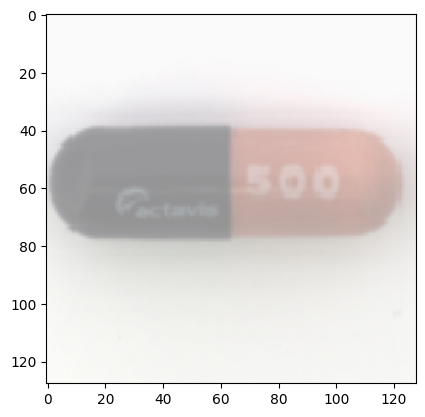

In [3]:
class CapsuleNegativeDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = glob.glob(os.path.join(root_dir, '*'))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image
    
if CHANNELS==3:
    normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
else:
    normalize = transforms.Normalize(mean=[0.5], std=[0.5])


transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomAffine(degrees=15, translate=(0.05, 0.05), scale=(1.1, 1.15),fill=255),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])

# Ścieżka do danych 

path = kagglehub.dataset_download("tladilebohang/capsule-defects")

dataset = CapsuleNegativeDataset(
    root_dir=os.path.join(path, 'capsule/negative'),
    transform=transform
)

# Podział danych
full_indices = np.arange(len(dataset))
train_val_indices, test_indices = train_test_split(
    full_indices, test_size=0.2, random_state=42, shuffle=True
)
train_indices, val_indices = train_test_split(
    train_val_indices, test_size=0.2, random_state=42, shuffle=True
)

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


#Print first image
data_iter = iter(train_loader)
images = next(data_iter)  # 

image = images[0]

image = (image+1)/2

image = image.permute(1, 2, 0).numpy()
image = np.array(image)
print(image.shape)

plt.imshow(image)


# VAE

In [ ]:
BCE_loss = nn.BCELoss(reduction='sum')
MSE_loss = nn.MSELoss(reduction='sum')


# Funkcja strat z modelem, ktory porownuje ekstaktowane cechy 
def CNN_loss(self,recon_x, x, mu, logvar, perceptual_loss):
    # Perceptual Loss dla cech
    percep_loss = perceptual_loss(recon_x, x)

    # Standardowa strata VAE (BCE + KLD)
    bce = F.binary_cross_entropy(recon_x, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Ważone sumowanie (można dostosować wagi)
    return 0.7 * percep_loss + 0.3 * bce + 0.1* kld


#Do testowania
def loss_tmp(recon_x, x, mu, logvar):
    MSE=0
    BCE=0
    # BCE = F.binary_cross_entropy(recon_x, x,reduction='sum')
    # BCE = F.mse_loss(recon_x, x, size_average=False)
    #recon_x_normalized = (recon_x + 1) / 2  # Przeskalowanie z [-1, 1] na [0, 1]
    #x_normalized = (x + 1) / 2
    BCE = BCE_loss(recon_x, x)/x.size(0)
    #MSE = MSE_loss(recon_x, x)/x.size(0)
    
    #MSE=MSE/x.size(0)
    

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    

    return BCE + MSE + KLD




def loss_from_article(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    # BCE = F.mse_loss(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD



In [ ]:
# Inicjalizacja

#model = VAE(device=device,result_dir='results/VAE',load_pretrained=True).to(device)

model = CNNVAE(device=device,result_dir='results/CNNVAE',load_pretrained=True).to(device)


if isinstance(model,CNNVAE):
    result_dir = 'results/CNNVAE'


if isinstance(model,VAE):
    result_dir = 'results/VAE'

dummy_input = torch.zeros(1, CHANNELS, IMG_SIZE, IMG_SIZE).to(device)  
summary(model, input_data=dummy_input)

# Pętla treningowa VAE

In [ ]:
# Główna pętla
best_loss = float('inf')
no_improve = 0  # Licznik epok bez poprawy

for epoch in range(1, EPOCHS + 1):
    train_loss=model.train_vae(epoch=epoch,dataloader=train_loader,loss_fn=loss_tmp)
    validate_loss = model.validate(epoch=epoch,dataloader=train_loader,loss_fn=loss_tmp)
    

    # Zapisywanie najlepszego modelu
    if train_loss < best_loss:
        best_loss = train_loss
        model.visualize_reconstruction(epoch=epoch,dataloader=train_loader)
        torch.save(model.state_dict(), f'{result_dir}/{name}_best.pth')
        no_improve = 0  
    else:
        no_improve += 1

    # Early stopping
    if no_improve >= PATIENCE:
        print(f'\nEarly stopping after {PATIENCE} epochs without improvement')
        break

    print(f'Epoch {epoch}: Train Loss = {train_loss:.4f} (Best: {best_loss:.4f})')

In [ ]:
def save_samples(samples, output_dir=result_dir):
    for i, sample in enumerate(samples):
        # Zapis do pliku PNG
        save_image(sample, os.path.join(output_dir, f"sample_{i}.png"))

In [ ]:
# Przykład użycia:
device = (
    torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cuda") if torch.cuda.is_available()
    else torch.device("cpu")
)
desired_variance = 0.5
desired_mu = 0.3

model = VAE().to(device)
state_dict = torch.load(result_dir+'vae_best.pth', map_location='cpu')
model.load_state_dict(state_dict)
model.eval()

mu = torch.tensor(desired_mu) * torch.ones(LATENT_DIM).to(device)
logvar = torch.log(torch.tensor(desired_variance)) * torch.ones(LATENT_DIM).to(device)
samples = model.generate_from_accurate_params(mu, logvar, num_samples=5, device=device)

save_samples(samples)

In [ ]:
# Przykład użycia:
device = (
    torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cuda") if torch.cuda.is_available()
    else torch.device("cpu")
)


model= VAE().to(device)
state_dict = torch.load(result_dir+'vae_best.pth', map_location='cpu')
model.load_state_dict(state_dict)
model.eval()

data = next(iter(test_loader)).to(device)
tmp_image = data[0]  # Zakładając, że data[0] to obrazy z batcha

# Dodaj wymiar batcha, jeśli obraz jest pojedynczy
tmp_image = tmp_image.unsqueeze(0)  # Dodaje wymiar batcha na początku



# Upewnij się, że obraz jest na odpowiednim urządzeniu
tmp_image = tmp_image.to(device)

# Przekazujemy obraz do modelu
recon, mu, logvar = model(tmp_image)

samples = model.generate_from_accurate_params(mu, logvar, num_samples=5, device=device)

save_samples(samples)

# GAN/DCGAN


In [ ]:


#gan=GAN(IMG_SIZE,CHANNELS,LATENT_DIM,device,result_dir="results/GAN",load_pretrained=True)

gan=CNNGAN(IMG_SIZE,CHANNELS,LATENT_DIM,device,result_dir="results/CNNGAN",load_pretrained=True)


# Pętla główna treningu GAN/CNNGAN

In [ ]:

best_g_loss = float('inf')
best_d_loss = float('inf')
no_improve = 0  # Licznik epok bez poprawy

for epoch in range(1, EPOCHS + 1):
    
    g_loss, d_loss = gan.train_gan(epoch,dataloader=train_loader)

    # Walidacja
    validate_loss = gan.validate(epoch, val_loader)

    # Wizualizacja rekonstrukcji
    gan.visualize_reconstruction(epoch)

    if g_loss < best_g_loss:
        best_g_loss = g_loss
        gan.save_generator()
        no_improve = 0
    else:
        no_improve += 1

    if d_loss < best_d_loss:
        best_d_loss = d_loss
        gan.save_discriminator()
        no_improve = 0
    else:
        no_improve += 1

    # Early stopping
    if no_improve >= PATIENCE:
        print(f'\nEarly stopping after {PATIENCE} epochs without improvement')
        break

    print(f'Epoch {epoch}: Validation Loss = {validate_loss:.4f} Generator Loss = {g_loss:.4f}, Discriminator Loss = {d_loss:.4f} \n (Best G: {best_g_loss:.4f} Best D: {best_d_loss:.4f}) ')


# Generating New Data for each method

In [4]:
#gan = GAN(IMG_SIZE,CHANNELS,LATENT_DIM,device,result_dir="results/GAN",load_pretrained=True)
#cnngan = CNNGAN(IMG_SIZE,CHANNELS,LATENT_DIM,device,result_dir="results/CNNGAN",load_pretrained=True)
#vae = VAE(device=device,result_dir='results/VAE',load_pretrained=True).to(device)
cnnvae = CNNVAE(device=device,result_dir='results/CNNVAE',load_pretrained=True).to(device)



#gan.generate_new_data(num_samples=50)
#cnngan.generate_new_data(num_samples=50)

#vae.generate_new_data(num_samples=50)
cnnvae.generate_similar_data(data=dataset,num_samples=50)


[INFO] Loaded best VAE weights.
